# Кластеризация временных рядов

## Кластеризация в ценообразовании
С помощью кластеризации можем выбрать товары, интересные с точки зрения ценообразования.

Кластеризуем по цене, обороту/прибыли, эластичности.
Выбирием группы:

* "Генераторы трафика" - товары с наибольшими продажами
* "Герераторы прибыли" - товары с низкой эластичностью с невысокой ценой и средними продажами
* "Промотовары" - товары продающиеся только в промо
* "Усилители прибыли" - товары с низкой эластичностью и эпизодическими характеристиками продаж

 # Как прогнозировать диапазоны

In [1]:
import pandas as pd
import numpy as np
# inport visualisation libraries
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
ZX_df = pd.read_csv('data/less4/lect/ZX10208_agr.csv')
ZX_df.dates = pd.to_datetime(ZX_df.dates)
ZX_df

,dates,SKU,price_per_sku,num_purchases
0,2018-04-20,59567,169.19,3
1,2018-04-24,59567,171.71,3
2,2018-04-27,59567,174.04,3
3,2018-04-30,59567,NaN,1
4,2018-05-03,59567,176.38,2
...,...,...,...,...
254,2019-12-23,82947,NaN,1
255,2019-12-24,82947,195.46,2
256,2019-12-25,82947,195.21,1
257,2019-12-26,82947,193.79,1


In [3]:
pivot_t = ZX_df.pivot_table(index='dates', columns='SKU', values='price_per_sku')
pivot_t

SKU,59567,82947
dates,,
2018-04-20,169.19,NaN
2018-04-24,171.71,NaN
2018-04-27,174.04,NaN
2018-05-03,176.38,NaN
2018-05-04,176.49,NaN
...,...,...
2019-12-21,NaN,195.96
2019-12-24,NaN,195.46
2019-12-25,NaN,195.21


<Axes: xlabel='dates'>

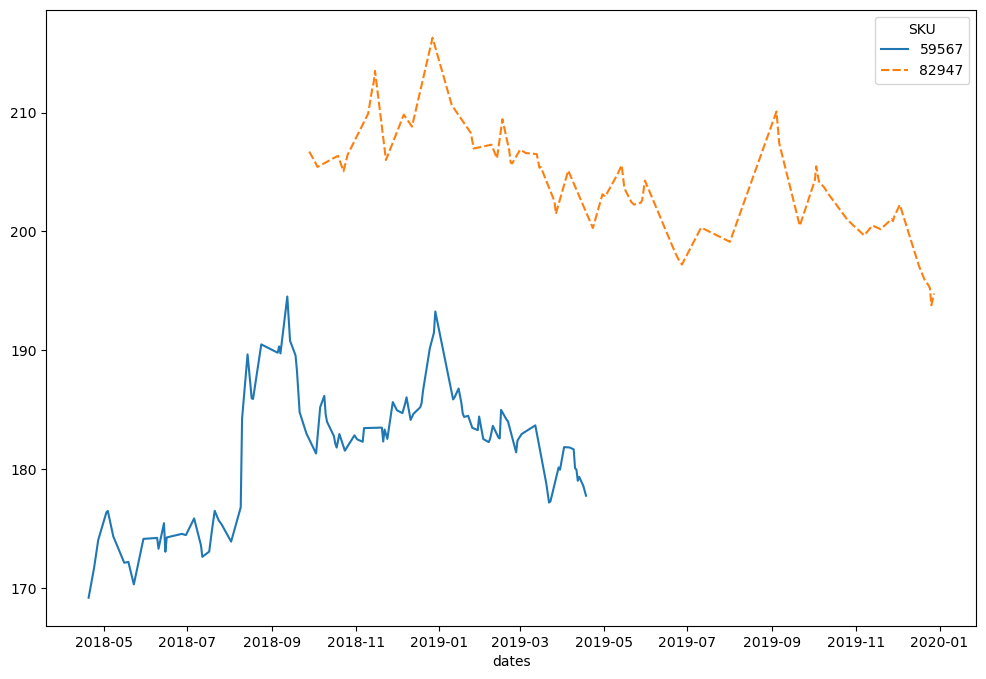

In [4]:
plt.figure(figsize=(12, 8))
# plt.xticks(rotation='vertical')
sns.lineplot(data=pivot_t)

In [5]:
df_59567 = ZX_df[ZX_df.SKU == 59567]

In [6]:
df_59567.describe()

,dates,SKU,price_per_sku,num_purchases
count,156,156.0,111.000000,156.000000
mean,2018-10-29 02:55:23.076923136,59567.0,181.747748,1.583333
min,2018-04-20 00:00:00,59567.0,169.190000,1.000000
25%,2018-08-05 00:00:00,59567.0,177.240000,1.000000
50%,2018-11-03 12:00:00,59567.0,182.690000,1.000000
75%,2019-01-19 12:00:00,59567.0,184.975000,2.000000
max,2019-04-21 00:00:00,59567.0,194.530000,3.000000
std,NaN,0.0,5.412514,0.735797


In [7]:
train_df = df_59567[df_59567.dates <= pd.to_datetime('2019-04-01')]
test_df = df_59567[df_59567.dates > pd.to_datetime('2019-04-01')]

In [8]:
train_df.shape

(145, 4)

In [9]:
test_df.shape

(11, 4)

In [10]:
train_df

,dates,SKU,price_per_sku,num_purchases
0,2018-04-20,59567,169.19,3
1,2018-04-24,59567,171.71,3
2,2018-04-27,59567,174.04,3
3,2018-04-30,59567,NaN,1
4,2018-05-03,59567,176.38,2
...,...,...,...,...
184,2019-03-23,59567,177.28,3
185,2019-03-24,59567,NaN,1
188,2019-03-29,59567,180.15,1
189,2019-03-30,59567,179.96,1


In [11]:
# Autoregressive Integrated Movind Average with boundaries
from statsmodels.tsa.arima.model import ARIMA

ARIMA_ = ARIMA(train_df.price_per_sku.values, order=(20, 1, 20))
ARIMA_model = ARIMA_.fit()
ARIMA_model.predict(start=len(train_df), end=len(train_df) + len(test_df) - 1)

/Users/adwiz/miniconda3/envs/pytorch/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


array([178.83997108, 178.58790167, 176.82471834, 177.3382998 ,
       175.6340768 , 176.42273327, 176.23205997, 176.3222431 ,
       177.71122515, 176.91345676, 177.65015664])

In [12]:
ARIMA_model.get_forecast(11).conf_int(.05)

array([[174.83832919, 182.84161298],
       [173.63122927, 183.54457406],
       [171.13314936, 182.51628732],
       [171.00437138, 183.67222822],
       [168.68990922, 182.57824438],
       [169.12675538, 183.71871116],
       [168.25035073, 184.21376921],
       [167.76039454, 184.88409165],
       [168.67925253, 186.74319778],
       [167.47775092, 186.34916261],
       [167.44434573, 187.85596754]])

In [13]:
test_df['ARIMA_low_boundary'] = ARIMA_model.get_forecast(11).conf_int(.05)[:,0]
test_df['ARIMA_high_boundary'] = ARIMA_model.get_forecast(11).conf_int(.05)[:,1]
test_df['ARIMA_model_prediction'] = ARIMA_model.predict(start=len(train_df), end=len(train_df) + len(test_df) - 1)

In [14]:
test_df.columns

Index(['dates', 'SKU', 'price_per_sku', 'num_purchases', 'ARIMA_low_boundary',
       'ARIMA_high_boundary', 'ARIMA_model_prediction'],
      dtype='object')

In [15]:
test_df

,dates,SKU,price_per_sku,num_purchases,ARIMA_low_boundary,ARIMA_high_boundary,ARIMA_model_prediction
192,2019-04-02,59567,181.86,2,174.838329,182.841613,178.839971
194,2019-04-06,59567,181.83,2,173.631229,183.544574,178.587902
195,2019-04-08,59567,NaN,1,171.133149,182.516287,176.824718
196,2019-04-09,59567,181.67,1,171.004371,183.672228,177.338300
197,2019-04-10,59567,180.08,2,168.689909,182.578244,175.634077
198,2019-04-11,59567,179.97,2,169.126755,183.718711,176.422733
199,2019-04-12,59567,179.03,1,168.250351,184.213769,176.232060
200,2019-04-13,59567,179.36,1,167.760395,184.884092,176.322243
202,2019-04-16,59567,178.61,2,168.679253,186.743198,177.711225
203,2019-04-18,59567,177.77,1,167.477751,186.349163,176.913457


In [16]:
col_list = ['dates', 'ARIMA_model_prediction', 'ARIMA_low_boundary', 'ARIMA_high_boundary', 'price_per_sku']

<Axes: xlabel='dates'>

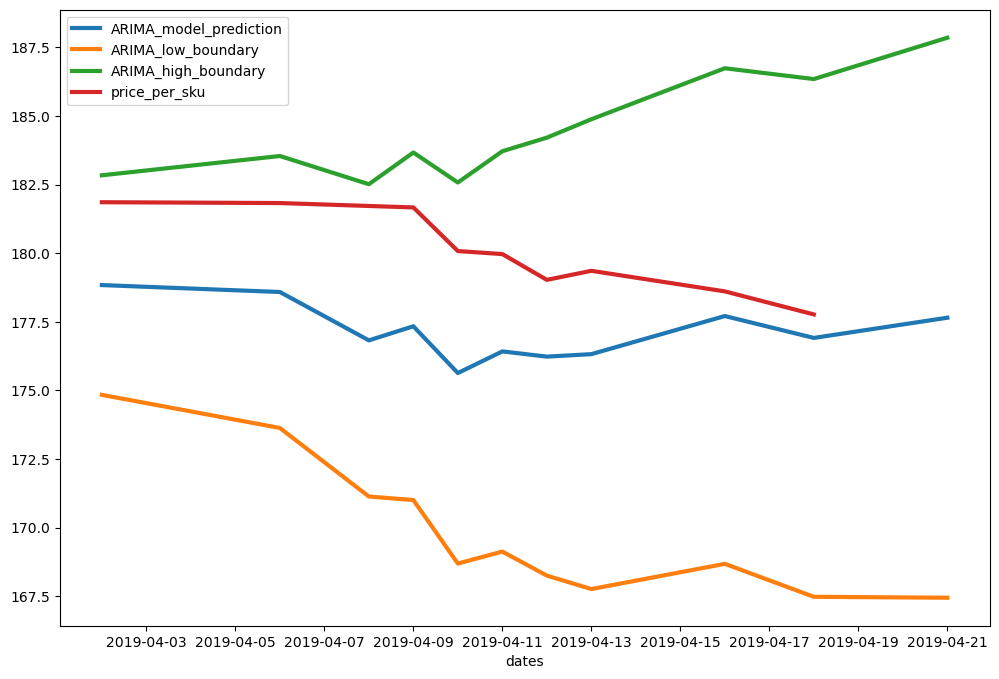

In [17]:
plt.figure(figsize=(12,8))
sns.lineplot(data=test_df[col_list].set_index('dates'), dashes=False, linewidth=3)

In [18]:
from prophet import Prophet

In [19]:
prophet = Prophet()

In [20]:
prophet.fit(train_df[['dates', 'price_per_sku']].rename(columns={'dates': 'ds', 'price_per_sku': 'y'}))

09:37:58 - cmdstanpy - INFO - Chain [1] start processing
09:37:58 - cmdstanpy - INFO - Chain [1] done processing


In [21]:
pred_df = prophet.predict(test_df[['dates']].rename(columns={'dates': 'ds'}))
pred_df

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-04-02,178.690077,176.506949,182.439011,178.690077,178.690077,0.739903,0.739903,0.739903,0.739903,0.739903,0.739903,0.0,0.0,0.0,179.429980
1,2019-04-06,178.352884,175.987969,182.087306,178.339345,178.363875,0.496136,0.496136,0.496136,0.496136,0.496136,0.496136,0.0,0.0,0.0,178.849020
2,2019-04-08,178.184288,173.677020,179.895387,178.139122,178.227876,-1.375966,-1.375966,-1.375966,-1.375966,-1.375966,-1.375966,0.0,0.0,0.0,176.808322
3,2019-04-09,178.099989,175.894029,181.802626,178.004210,178.192497,0.739903,0.739903,0.739903,0.739903,0.739903,0.739903,0.0,0.0,0.0,178.839892
4,2019-04-10,178.015691,174.812725,180.707255,177.846177,178.171074,-0.174937,-0.174937,-0.174937,-0.174937,-0.174937,-0.174937,0.0,0.0,0.0,177.840754
5,2019-04-11,177.931393,174.321908,180.166488,177.690311,178.146054,-0.719854,-0.719854,-0.719854,-0.719854,-0.719854,-0.719854,0.0,0.0,0.0,177.211539
6,2019-04-12,177.847095,176.170545,182.212889,177.519672,178.146157,1.355207,1.355207,1.355207,1.355207,1.355207,1.355207,0.0,0.0,0.0,179.202302
7,2019-04-13,177.762796,175.109217,181.220322,177.343555,178.148499,0.496136,0.496136,0.496136,0.496136,0.496136,0.496136,0.0,0.0,0.0,178.258932
8,2019-04-16,177.509902,175.267731,181.346956,176.985225,177.995034,0.739903,0.739903,0.739903,0.739903,0.739903,0.739903,0.0,0.0,0.0,178.249805
9,2019-04-18,177.341305,173.831104,179.830878,176.713874,177.934996,-0.719854,-0.719854,-0.719854,-0.719854,-0.719854,-0.719854,0.0,0.0,0.0,176.621452


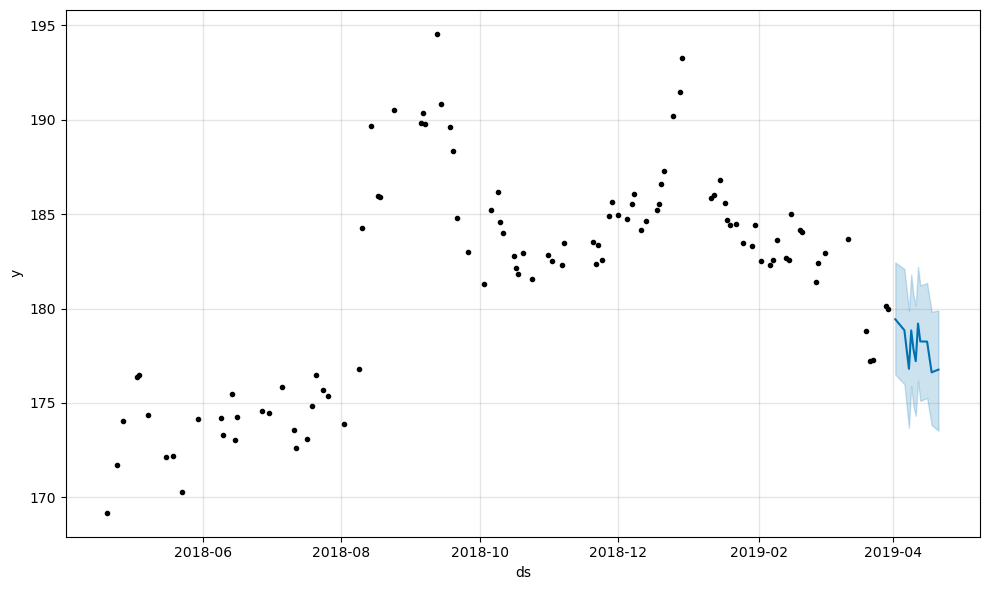

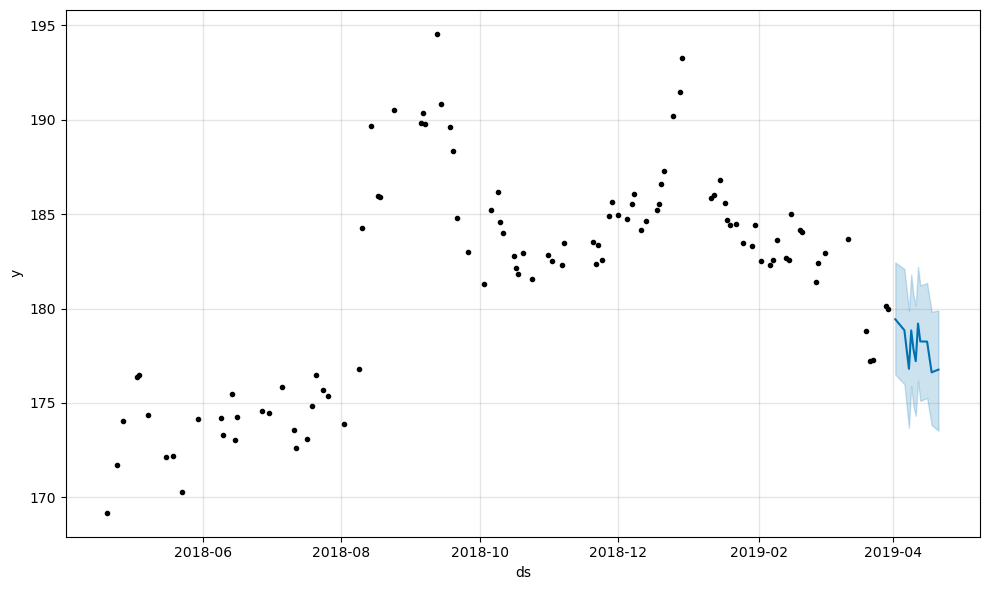

In [22]:
prophet.plot(pred_df)

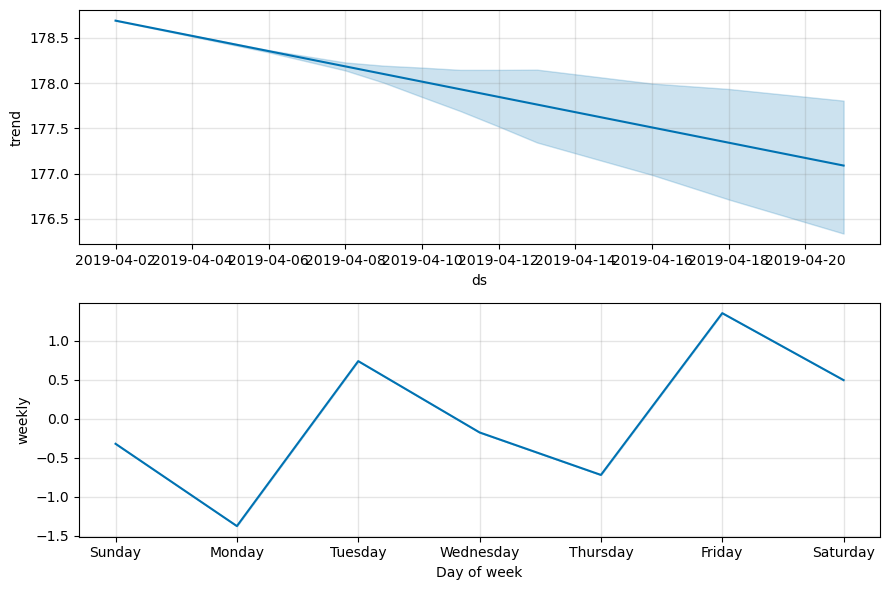

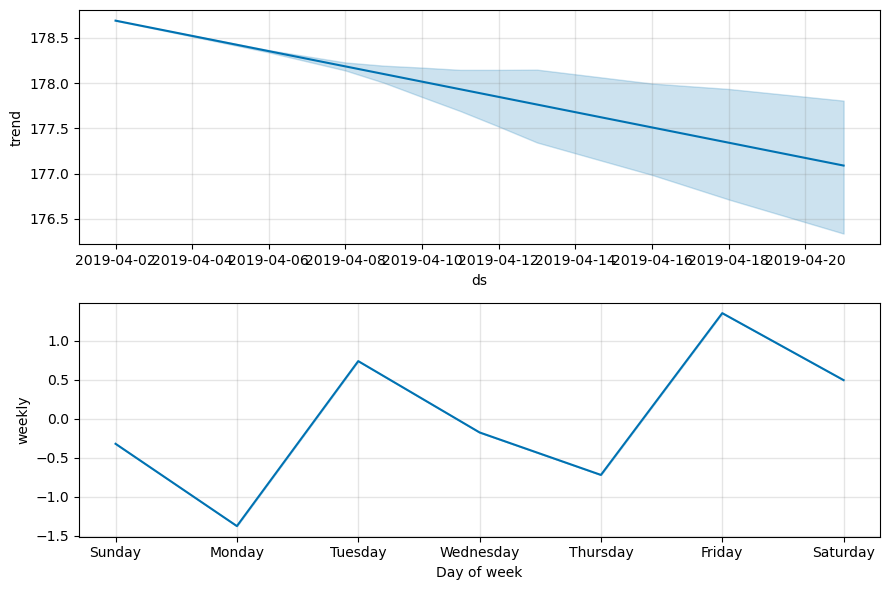

In [23]:
prophet.plot_components(pred_df)

In [24]:
test_df['prophet_model_prediction'] = pred_df['yhat'].values

<Axes: xlabel='dates'>

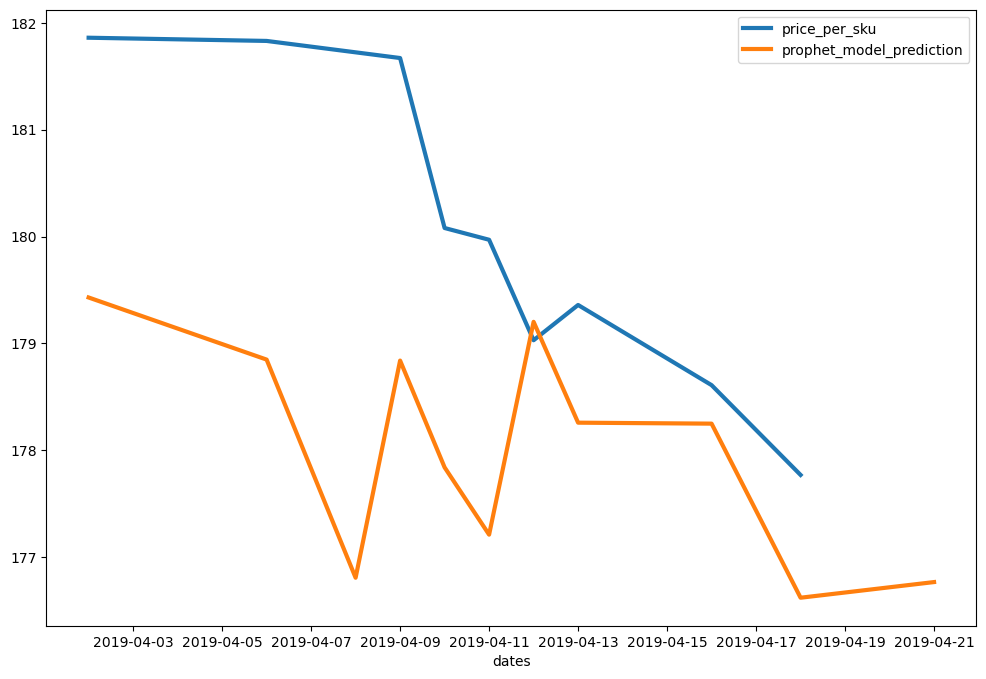

In [25]:
plt.figure(figsize=(12,8))
sns.lineplot(data=test_df[['dates', 'price_per_sku', 'prophet_model_prediction']].set_index('dates'), dashes=False, linewidth=3)

In [32]:
from orbit.utils.dataset import load_iclaims
from orbit.models import DLT
from orbit.diagnostics.plot import plot_predicted_data

In [43]:
dlt = DLT(
    response_col='price_per_sku', 
    date_col='dates',
    # seasonality=365,
)

In [44]:
dlt.fit(df=train_df[['dates', 'price_per_sku']])

2023-12-17 09:49:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [45]:
pred = dlt.predict(test_df[['dates']])

In [49]:
pred

,dates,prediction_5,prediction,prediction_95
0,2019-04-02,176.849172,179.608878,183.178889
1,2019-04-06,174.877253,179.701947,184.217037
2,2019-04-08,173.770906,179.716219,184.800842
3,2019-04-09,172.372177,179.077880,186.867941
4,2019-04-10,171.897268,179.344581,187.302111
5,2019-04-11,171.189472,179.620308,188.025304
6,2019-04-12,170.778946,179.256049,187.961470
7,2019-04-13,170.649942,179.254121,188.530603
8,2019-04-16,167.668298,178.814501,188.804393
9,2019-04-18,167.669838,179.124615,190.314218


In [46]:
pred.columns

Index(['dates', 'prediction_5', 'prediction', 'prediction_95'], dtype='object')

In [48]:
from orbit.diagnostics.plot import plot_predicted_data

In [50]:
test_df[['Orbit_lower_bound', 'Orbit_pred', 'Orbit_upper_bound']] = \
pred[['prediction_5', 'prediction', 'prediction_95']].values

<Axes: xlabel='dates'>

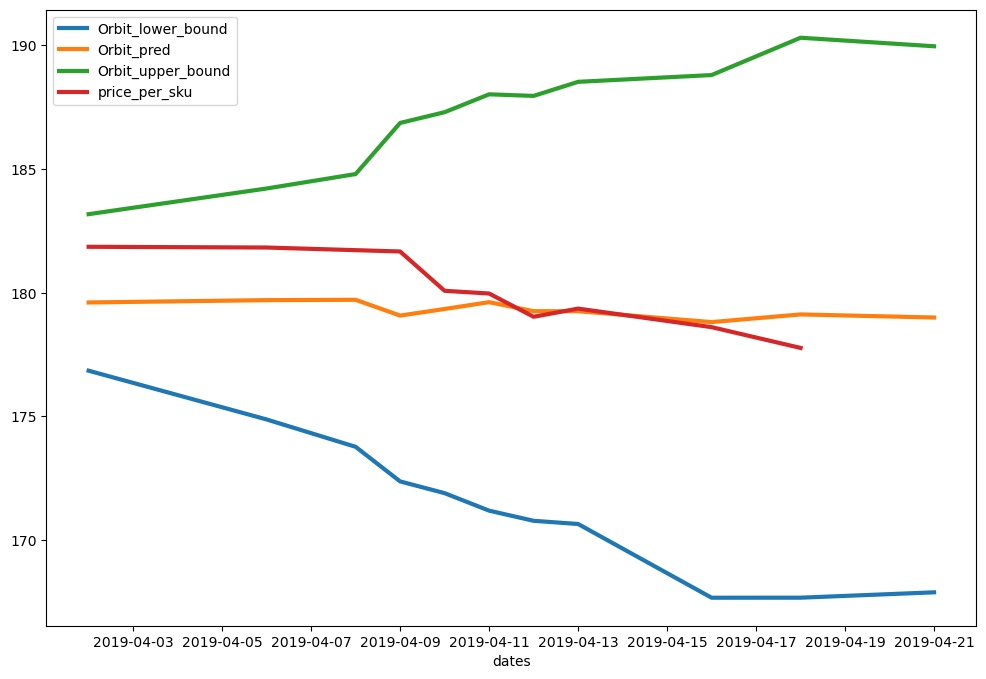

In [53]:
col_list = ['dates', 'Orbit_lower_bound', 'Orbit_pred', 'Orbit_upper_bound', 'price_per_sku']
plt.figure(figsize=(12,8))
sns.lineplot(data=test_df[col_list].set_index('dates'), dashes=False, linewidth=3)

In [54]:
test_df

,dates,SKU,price_per_sku,num_purchases,ARIMA_low_boundary,ARIMA_high_boundary,ARIMA_model_prediction,prophet_model_prediction,Orbit_lower_bound,Orbit_pred,Orbit_upper_bound
192,2019-04-02,59567,181.86,2,174.838329,182.841613,178.839971,179.429980,176.849172,179.608878,183.178889
194,2019-04-06,59567,181.83,2,173.631229,183.544574,178.587902,178.849020,174.877253,179.701947,184.217037
195,2019-04-08,59567,NaN,1,171.133149,182.516287,176.824718,176.808322,173.770906,179.716219,184.800842
196,2019-04-09,59567,181.67,1,171.004371,183.672228,177.338300,178.839892,172.372177,179.077880,186.867941
197,2019-04-10,59567,180.08,2,168.689909,182.578244,175.634077,177.840754,171.897268,179.344581,187.302111
198,2019-04-11,59567,179.97,2,169.126755,183.718711,176.422733,177.211539,171.189472,179.620308,188.025304
199,2019-04-12,59567,179.03,1,168.250351,184.213769,176.232060,179.202302,170.778946,179.256049,187.961470
200,2019-04-13,59567,179.36,1,167.760395,184.884092,176.322243,178.258932,170.649942,179.254121,188.530603
202,2019-04-16,59567,178.61,2,168.679253,186.743198,177.711225,178.249805,167.668298,178.814501,188.804393
203,2019-04-18,59567,177.77,1,167.477751,186.349163,176.913457,176.621452,167.669838,179.124615,190.314218


In [55]:
from sklearn.ensemble import GradientBoostingRegressor

GBR = GradientBoostingRegressor()

In [60]:
import lightgbm

In [59]:
from xgboost.sklearn import XGBRegressor
from functools import partial

# Какую метрику качества можно выбрать

# RMLSE

# Метрика Intersection over Union (IoU), также известная как Jaccard index, — число от 0 до 1, показывающее, насколько у двух объектов (эталонного ...